In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmlstm_network import HMLSTMNetwork
import tensorflow as tf
from text_input_utils import prepare_inputs
import tensorflow as tf
from string import ascii_lowercase

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Regression example

In [2]:
# simulate multiresolution data
num_signals = 1000
signal_length = 100
x = np.linspace(0, 10 * np.pi, signal_length)
signals = []
for _ in range(num_signals):
    # sin waves
    signals.append(np.random.normal(0, .1, size=signal_length) +
#            (2 * np.sin((5/np.pi) * x + (np.random.random() * np.pi * 10)))
           + (5 * np.sin((3/np.pi)* x + (np.random.random() * np.pi * 10)))
           +( 10 * np.sin((1/np.pi) * x + (np.random.random() * np.pi * 10))))

#     # block functions
#     y = np.arange(signal_length)
#     off = np.random.randint(5)
#     mod = np.mod(y + off, np.ones(signal_length) * 5)
#     s = 
#     signals.append([])

split = int(num_signals * .8)
train = signals[:split]
test = signals[split:]

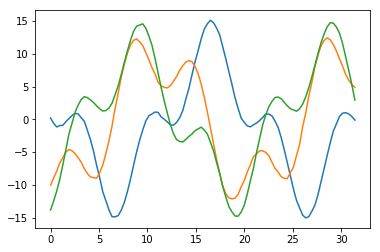

In [3]:
# example signals
plt.plot(x, signals[0])
plt.plot(x, signals[1]);
plt.plot(x, signals[2]);

In [4]:
# how far ahead to predict
steps_ahead = 10

In [5]:
# prepare data
train_batches_in = []
train_batches_out = []
batch_size = 1
start = 0
while start + batch_size < len(train):
    batch = train[start: start + batch_size]
    
    # five step ahead
    train_batches_in.append(np.array([s[:-steps_ahead] for s in batch]).reshape(batch_size, -1, 1))
    train_batches_out.append(np.array([s[steps_ahead:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size
    
    
batch_size = 1
start = 0
test_batches_in = []
test_batches_out = []
while start + batch_size < len(test):
    batch = test[start: start + batch_size]
    
    test_batches_in.append(np.array([s[:-steps_ahead] for s in batch]).reshape(batch_size, -1, 1))
    test_batches_out.append(np.array([s[steps_ahead:] for s in batch]).reshape(batch_size, -1, 1))

    start += batch_size

In [6]:
tf.reset_default_graph()
network = HMLSTMNetwork(input_size=1, task='regression', hidden_state_sizes=100,
                       embed_size=150, out_hidden_size=100, num_layers=3)

In [ ]:
network.train(train_batches_in, train_batches_out, load_existing_vars=False
              , epochs=3)

In [ ]:
batch_num = 0

In [ ]:
boundaries = network.predict_boundaries(test_batches_in[batch_num][0])
print(boundaries[0])

In [ ]:
# test that indicators are valid
# TODO: figure out why first element is sometimes invalid
b = boundaries[0]
for l in range(1, len(b)):
    for i in range(1, len(b[0])):
        if b[l][i] == 1.:
            if b[l][i - 1] == 0.\
            and b[l][i - 2] == 0 \
            and b[l - 1][i] == 0. \
            and b[l - 1][i - 1] == 0. \
            and (l == (len(b) - 1) or 
                 b[l + 1][i - 1] == 0):
                print(l, i)
                raise ValueError("Something may not be right (check)")

In [ ]:
for l in range(0, len(b)):
    print(b[l][i - 5:i + 5])

In [ ]:
reg_predictions = network.predict(test_batches_in[batch_num][0])

In [ ]:
plt.plot(test_batches_in[batch_num][0][steps_ahead:], label='truth')
plt.plot(reg_predictions.flatten(), label='prediction')

colors = ['r', 'b', 'g', 'o']
for l, layer in enumerate(boundaries[0]):
    for i, indicator in enumerate(layer):
        if indicator == 1.:
            p = 1 / len(boundaries[0])
            plt.axvline(i, color=colors[l], ymin=(p*l), ymax=(p*(l + 1)), alpha=.3)
            
plt.legend();            

### Text classificaiton example

In [13]:
tf.reset_default_graph()
network = HMLSTMNetwork(output_size=29, input_size=29,
                        embed_size=1024, out_hidden_size=500,
                        hidden_state_sizes=200)

In [14]:
batch_size = 2
truncate_len = 100
num_layers = 3
num_batches = 100

inputs = prepare_inputs(
    batch_size=batch_size, truncate_len=truncate_len, num_batches=num_batches)

In [16]:
# test on last input\
network.train(inputs[0][:-1], inputs[1][:-1], load_existing_vars=False)

Epoch 0
loss: 329.582
loss: 312.169
loss: 312.041
loss: 302.142
loss: 291.715
loss: 285.826
loss: 287.131
loss: 298.26
loss: 290.96
loss: 287.557
loss: 280.658
loss: 302.381
loss: 284.644
loss: 290.282
loss: 289.126
loss: 287.074
loss: 276.452
loss: 283.661
loss: 275.376
loss: 270.881
loss: 265.371
loss: 269.339
loss: 274.054
loss: 264.18
loss: 309.129
loss: 275.981
loss: 267.486
loss: 254.889
loss: 272.733
loss: 266.149
loss: 257.561
loss: 244.552
loss: 248.386
loss: 253.213
loss: 255.444
loss: 246.38
loss: 237.243
loss: 263.26
loss: 265.391
loss: 254.649
loss: 262.682
loss: 254.499
loss: 265.148
loss: 252.64
loss: 246.217
loss: 240.431
loss: 254.006
loss: 244.1
loss: 261.737
loss: 237.258
loss: 239.588
loss: 249.744
loss: 271.837
loss: 239.876
loss: 245.448
loss: 253.479
loss: 252.015
loss: 262.011
loss: 249.549
loss: 251.422
loss: 256.93
loss: 263.165
loss: 244.972
loss: 235.392
loss: 227.187
loss: 235.85
loss: 237.28
loss: 237.821
loss: 259.78
loss: 227.726
loss: 230.643
loss: 234.

In [17]:
# predictions on last input
indicators = network.predict_boundaries(inputs[0][-1Wfast][0], reuse=True)
indicators

loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm.ckpt


array([[[ 0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
          1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
          1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
          0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
          0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
          0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
          1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
          1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.

In [18]:
# predictions on last input
predictions = network.predict(inputs[0][-1][0], reuse=True)

loading variables...
INFO:tensorflow:Restoring parameters from ./hmlstm.ckpt


In [19]:
def get_text(encoding):
    prediction = ''
    
    for char in np.squeeze(encoding):
        max_likelihood = np.where(char == np.max(char))[0][0]
        if max_likelihood < 26:
            prediction += ascii_lowercase[max_likelihood]
        elif max_likelihood == 26:
            prediction += ','
        elif max_likelihood == 27:
            prediction += '.'
        elif max_likelihood == 28:
            prediction += ' '
    
    return prediction

In [20]:
get_text(predictions)

'er       ahes aoeuan   ah te tn er   eng   t ahnrd ae t tan  wh was  an   h eshtou  aoess eahhhhoaen'

In [21]:
get_text(inputs[0][-1][0][1:])

'ell. and this promises to be interesting. it would be a pity to miss it.   but your client     neve'